# Common Sample astrometric properties

In [1]:
import os, glob, getpass, sys, warnings, itertools

import peakutils
import numpy as np

import matplotlib.pyplot as plt
from astropy.table import Table, join, vstack, hstack, Column, MaskedColumn, unique
from astropy.utils.exceptions import AstropyWarning
from astropy.coordinates import SkyCoord
from astropy import units as u


user = getpass.getuser()
sys.path.append('/Users/' + user + '/Dropbox/my_python_packages')
path = '../' 
sys.path.append(path)
from gaia.Basic import Basic as Basic
from gaia.Basic_Plotters import Basic_Plotters as Basic_Plotters
from gaia.cluster_comparison_n import Comparison_n as Comparison
from extra_codes import sample_comp    as samp_comp

In [2]:
# Path to data =================================
warnings.simplefilter('ignore', AstropyWarning)
path_control   = path + 'sample_control/OPH___control_sample.vot'
path_wise_img  = path + 'sample_control/wise_RGB_img.fits'
path_gaia      = path + 'sample_gaia/gaia_sample_cleaned.vot'
path_entire    = path + 'sample_comp/entire_sample_case_0.vot'


# Read Data ====================================
sample_gaia    = Table.read(path_gaia,    format = 'votable')  ; sample_gaia.label    = 'Gaia'
sample_control = Table.read(path_control, format = 'votable')
sample_entire  = Table.read(path_entire,  format = 'votable')
sample_common  = sample_entire[sample_entire['DOH'] == 'YYY']

# Combine with Gaia Cat to get all cols ========
sample_control = join(sample_gaia, Table([sample_control['source_id']])) ; sample_control.label = 'Control'
sample_common  = join(sample_gaia, Table([sample_common['source_id']]))  ; sample_common.label  = 'Common'
sample_entire  = join(sample_gaia, Table([sample_entire['source_id']]))  ; sample_entire.label  = 'Combined'

# Extract Control NOT in Common ================
sample_control_nc = list(set(sample_control['source_id']) - set(sample_common['source_id']))
sample_control_nc = join(Table([sample_control_nc], names = ['source_id']), sample_gaia) ; sample_control_nc.label = 'Control'
print('N Control Sources NOT in common: ', len(sample_control_nc))

N Control Sources NOT in common:  40


## 1.- Examine Source sky-projected distribution

In [3]:
# Mark Highest extinction point for later ======
l1688                             = SkyCoord('16h26m57s', '-24d31m00s', frame='icrs') # Obtained by eye (see previous notebook, Cell #8)
sample_common['l1688_sep']        = [l1688.separation(SkyCoord(inp['ra'], inp['dec'], unit = (u.deg, u.deg))).degree for inp in sample_common]
sample_common['l1688_sep'].unit   = u.degree
sample_common['l1688_sep'].format = '%5.3f'

In [4]:
# Study object distribution =====================
radius            = 0.6
sample_common_r06 = sample_common[sample_common['l1688_sep'] < radius]
n_els_r06         = len(sample_common_r06)

print(f'L1688 Core Coordinates: {l1688.ra.deg:17.1f}, {l1688.dec.deg:7.1f}')
print(f'N_Elements  inside r < 0.6\degr: {n_els_r06:17.1f}')
print(f'% Elements  inside r < 0.6\degr: {n_els_r06/len(sample_common) * 100.:17.1f}')


# Find how many are new =========================
control_r06_y = join(sample_common_r06, sample_control, keys='source_id')   
control_r06_n = np.setdiff1d(sample_common_r06['source_id'], sample_control['source_id'])
control_r06_n = join(sample_common_r06, Table([control_r06_n], names=['source_id']))

print()
print(f'Total Control-N sources: {len(control_r06_n):25.1f}')
print(f'Total Control-Y sources: {len(control_r06_y):25.1f}')

L1688 Core Coordinates:             246.7,   -24.5
N_Elements  inside r < 0.6\degr:             125.0
% Elements  inside r < 0.6\degr:              32.0

Total Control-N sources:                      12.0
Total Control-Y sources:                     113.0


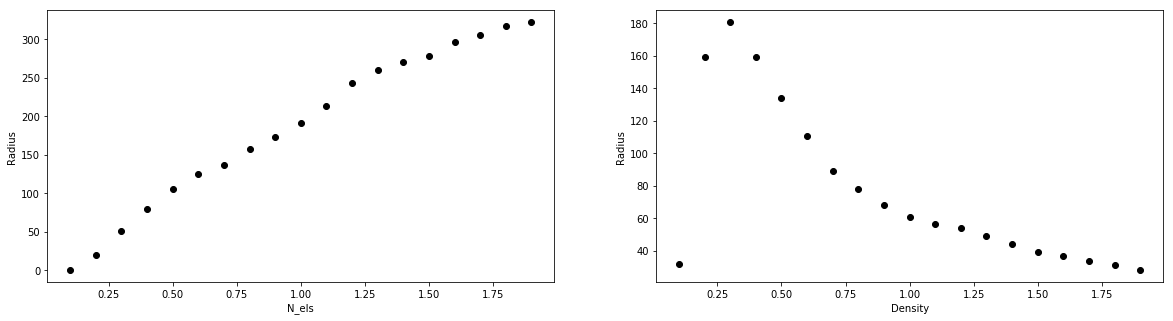

Average Distance inside r <0.6degs:       138.6 +/- 4.3
Average Distance outside r <0.6degs:      139.9 +/- 3.7


In [5]:
# Estimate Density distribution of objects ======
radius = np.arange(0.1,2,0.1)
n_els, dens = [], []

for radii in radius:
    els  = len(sample_common[sample_common['l1688_sep'] < radii])
    n_els.append(els)
    dens.append(els/(np.pi * (radii**2)))

fig = plt.figure(figsize=[20,5])
plt.subplot(121)
plt.xlabel('N_els')
plt.ylabel('Radius')
plt.plot(radius, n_els, 'ko')

plt.subplot(122)
plt.xlabel('Density')
plt.ylabel('Radius')
plt.plot(radius, dens, 'ko')

plt.show()


# Investigate distances distribution ===
reg_inn = sample_common[sample_common['l1688_sep'] < 0.6]
reg_out = sample_common[sample_common['l1688_sep'] > 0.6]

textt   = itertools.cycle(['Average Distance inside r <0.6degs: ', 'Average Distance outside r <0.6degs:'])
for inp in [reg_inn, reg_out]:
    print(f'{next(textt)} {inp["distance"].mean():10.1f} +/- {inp["distance"].std():3.1f}')

## 2.- Examine proper motions distribution

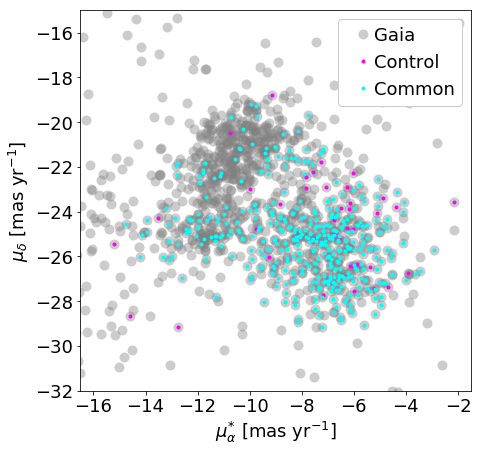

In [6]:
# Plot PMRA VS PMDEC ===========================
clusters    = [sample_gaia, sample_control_nc, sample_common]
figname     = '05_astrometry_analysis_0.pdf'


inp_col_1   = 'pmra'
inp_col_2   = 'pmdec'
label_1     = r'$\mu_{\alpha}^{*}$ [mas yr$^{-1}$]'
label_2     = r'$\mu_{\delta}$ [mas yr$^{-1}$]'
x_err       = clusters[0][inp_col_1 + '_error'].mean()
y_err       = clusters[0][inp_col_2 + '_error'].mean()

ftsize      = 18
xlim        = [-16.5,-1.5]
ylim        = [-32,-15]
markersizes = itertools.cycle([10,4,4])
colors      = itertools.cycle(['grey', 'magenta', 'cyan'])
alphas      = itertools.cycle([0.4, 1.0, 1.0])


# Start Plot ==========
fig = plt.figure(figsize=[7,7])

plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel(label_1, fontsize = ftsize)
plt.ylabel(label_2, fontsize = ftsize)
plt.xticks(fontsize = ftsize)
plt.yticks(fontsize = ftsize)

for cluster in clusters:
    plt.plot(cluster[inp_col_1], cluster[inp_col_2], 'o', markersize = next(markersizes),
             mew = 0, color = next(colors), alpha = next(alphas), label = cluster.label)

plt.legend(loc = 'upper right', fontsize = ftsize, handletextpad= -0.4, framealpha = 1.0)

plt.show()
fig.savefig(figname, bbox_inches = 'tight', overwrite = True)

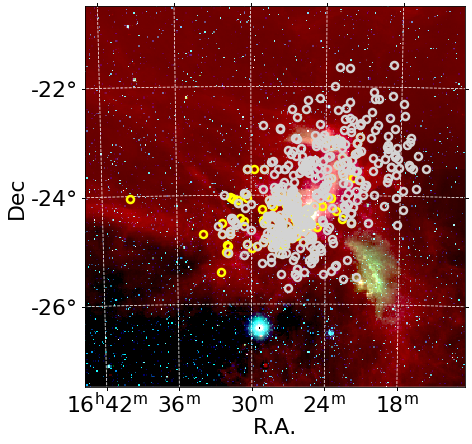

In [7]:
# Plot Outputs =================================
clusters = Comparison()
clusters.load_clusters(sample_control, cluster_list = [sample_common])

clusters.read_wise_fits(wise_fits_path=path_wise_img)
clusters.plot_wise_img_1(markersize=7, mew=2.5, figname='05_astrometry_analysis_1.pdf',
                           control_on_top = False, ftsize=22, mec_1='yellow', mec_2='lightgrey', legend_color='no_legend', cl_index = 0)

## 3.- Examine histograms & Compare to UpperSco

RAJ2000_2       242.0 +/-   3.6
DEJ2000_2       -23.7 +/-   3.2
plxTRIG           7.1 +/-   0.5
pmRA            -11.7 +/-   3.1
pmDE            -23.9 +/-   1.9


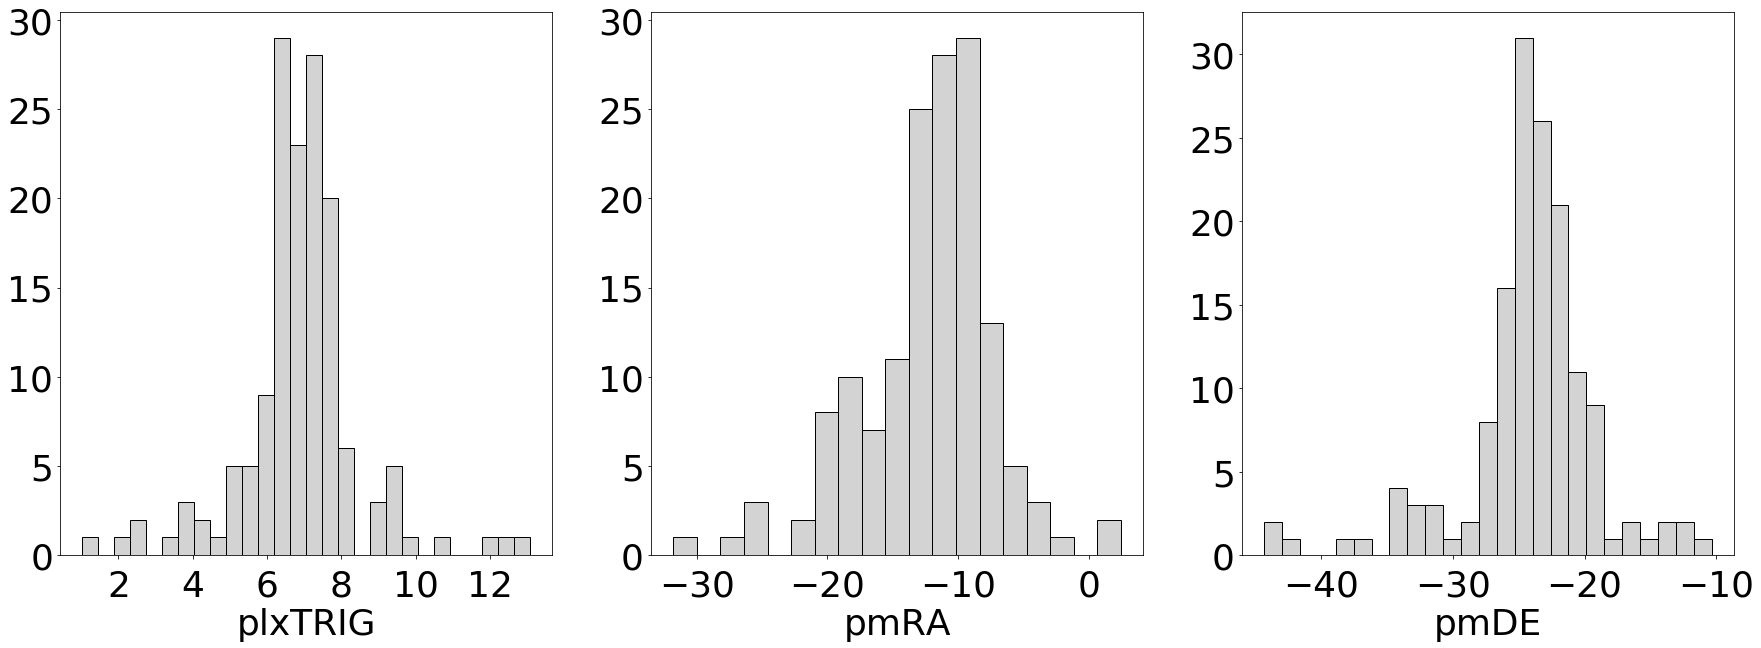

In [8]:
# Read Galli2018 table ====================================
galli = Table.read('galli_2018.vot') # USco members from Galli et al. 2018 (MNRAS)
galli.convert_bytestring_to_unicode()

coords             = SkyCoord(galli['RAJ2000'], galli['DEJ2000'], unit=(u.hourangle, u.deg))
galli['RAJ2000_2'] = coords.ra.deg
galli['DEJ2000_2'] = coords.dec.deg

# Extract Objects with Trigonometric Parallax =============
galli   = galli[galli['plxTRIG'].mask == False]
control = True  #Dealing with control sample?
if control:
    galli_2 = galli[galli['CTRL'] == 'Y']

galli_cols = []
for col in ['RAJ2000_2', 'DEJ2000_2', 'plxTRIG', 'pmRA', 'pmDE']:
    print(f'{col:10s} {galli_2[col].mean():10.1f} +/- {galli_2[col].std():5.1f}')
    galli_cols.append(galli_2[col].mean())
    
# Plot Histogram ===========
galli = Basic_Plotters(galli)
hists = galli.plot_3_hist(inp_col_1='plxTRIG', inp_col_2='pmRA', inp_col_3='pmDE')

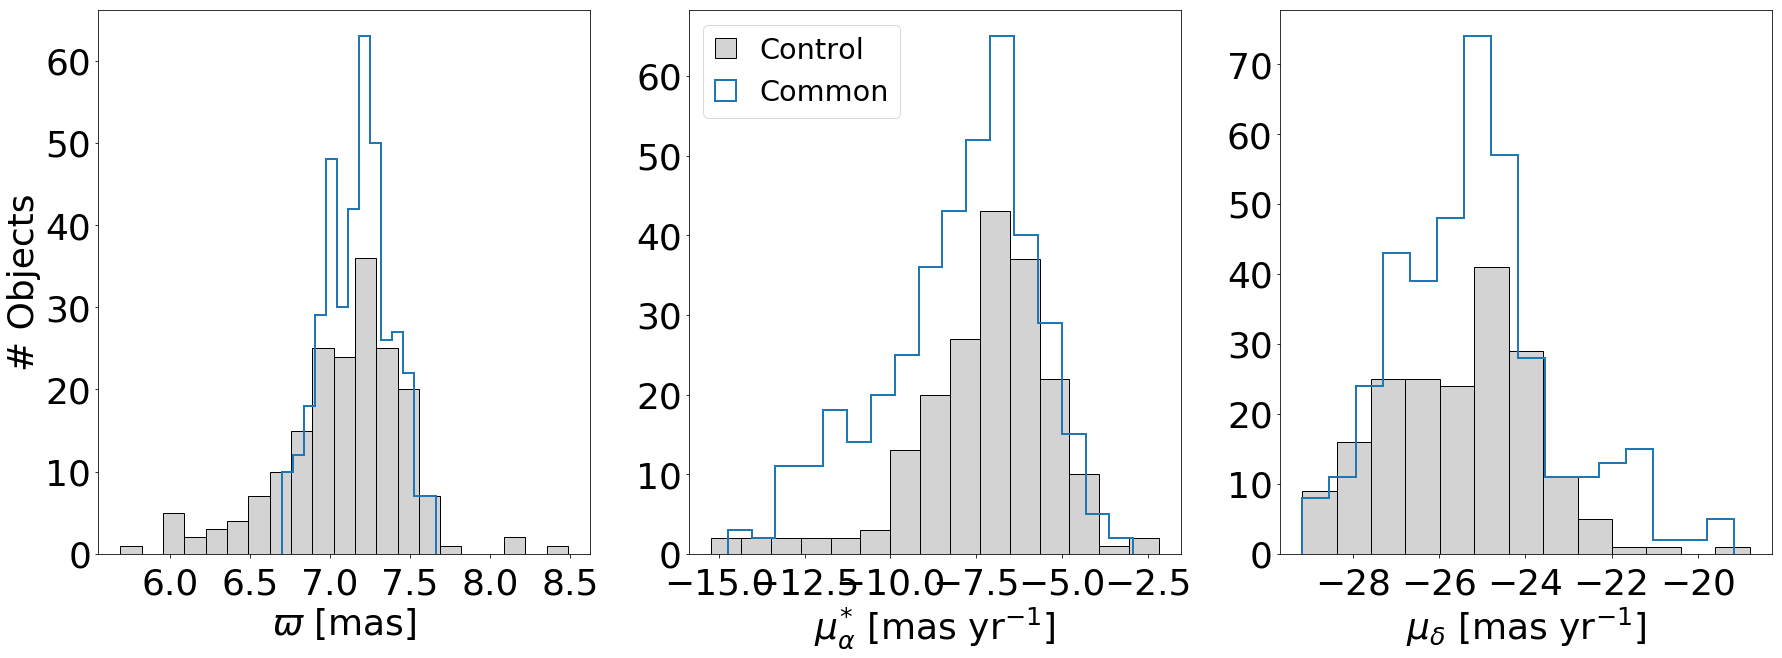

PMRA  Gaussian Fit Results ===================
Amplitude 1:    53.9  +/-  4.1
Mean 1:         -6.9  +/-  0.1
Std 1:           1.4  +/-  0.1

Amplitude 2:    17.6  +/-  1.6
Mean 2:        -10.4  +/-  0.5
Std 2:           2.0  +/-  0.4

PMDEC Gaussian Fit Results ===================
Amplitude 1:    61.2  +/-  2.0
Mean 1:        -25.4  +/-  0.1
Std 1:           1.5  +/-  0.1

Amplitude 2:    15.6  +/-  4.4
Mean 2:        -21.6  +/-  0.1
Std 2:           0.4  +/-  0.2


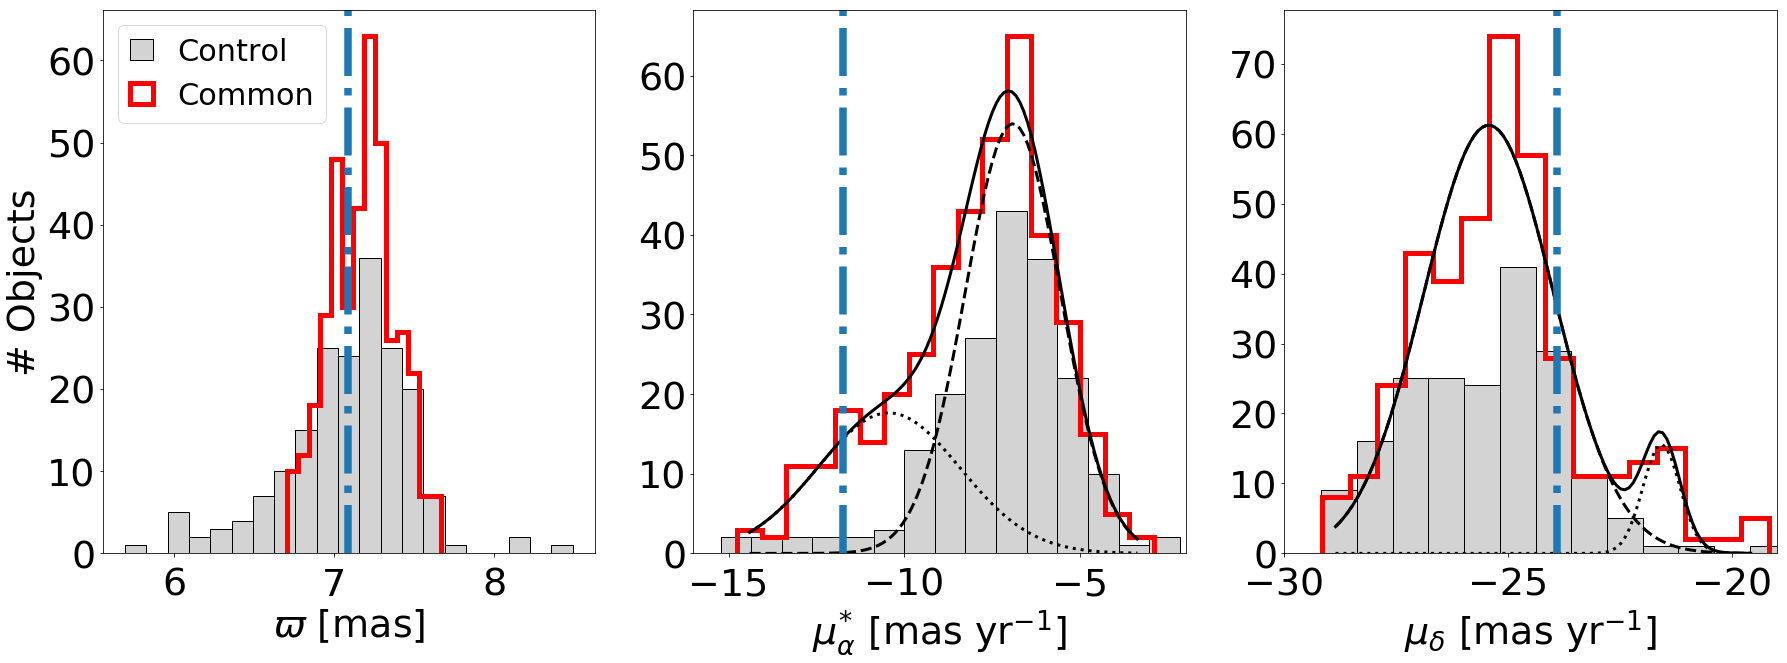

In [9]:
# Fit 2 Gaussians to the histograms =======================
hist_0    = clusters.plot_3_hist(fig = True, ylabel_1='# Objects')
fig       = plt.figure(figsize=[30,10])
index     = 1
linewidth = 5
ftsize    = 38
cols      = ['parallax', 'pmra', 'pmdec']
colors    = itertools.cycle(["red"]) # Input must be iterable
fig0      = False

# Parallax Hist ===============
plt.subplot(131)
out = clusters.plot_hist(inp_col = cols[0], linewidth = linewidth, colors= colors, fig = fig0, ftsize=ftsize, x_bins=5, show_legend=True, show_ylabel = '# Objects')
plt.axvline(x=galli_cols[2], linestyle = '-.', linewidth = linewidth*1.5)

# PMRA Hist ===================
print('PMRA  Gaussian Fit Results ===================')
plt.subplot(132)
out     = clusters.plot_hist(inp_col = cols[1], linewidth = linewidth, colors= colors, fig = fig0, ftsize=ftsize, x_bins=5, xlim=[-16,-2])
gfits_r = samp_comp.gauss_2_fit(out['bin_c'][index], out['bin_h'][index], gauss_1 = (65, -7,  2.), gauss_2 = (10, -14, 2.), fit_LevMar=True, verbose = True, vline=None)
plt.axvline(x=galli_cols[3], linestyle = '-.', linewidth = linewidth*1.5)
print()

# PMDEC Hist ==================
print('PMDEC Gaussian Fit Results ===================')
plt.subplot(133)
out     = clusters.plot_hist(inp_col = cols[2], linewidth = linewidth, colors= colors, fig = fig0, ftsize=ftsize, x_bins=4, xlim=[-30,-19])
gfits_d = samp_comp.gauss_2_fit(out['bin_c'][index], out['bin_h'][index], gauss_1 = (70, -25,  0.5), gauss_2 = (15, -22, 0.5), fit_LevMar=True, verbose = True, vline=None)
plt.axvline(x=galli_cols[4], linestyle = '-.', linewidth = linewidth*1.5)

plt.show()
figname = '05_astrometry_analysis_2.pdf'
fig.savefig(figname, bbox_inches = 'tight', overwrite = True)

In [10]:
# LATEX Table =================
col_0   = ['Mean', 'FWHM', 'Mean', 'FWHM']
s2fwhm  = 2.355 # Sigma >> FWHM for Gaussian Distribution
col_1_m = [gfits_r.mean_0.value, s2fwhm*gfits_r.stddev_0.value, gfits_r.mean_1.value, s2fwhm*gfits_r.stddev_1.value]
col_2_m = [gfits_d.mean_0.value, s2fwhm*gfits_d.stddev_0.value, gfits_d.mean_1.value, s2fwhm*gfits_d.stddev_1.value]

col_1_e = [gfits_r.mean_0_err, s2fwhm*gfits_r.stddev_0_err, gfits_r.mean_1_err, s2fwhm*gfits_r.stddev_1_err]
col_2_e = [gfits_d.mean_0_err, s2fwhm*gfits_d.stddev_0_err, gfits_d.mean_1_err, s2fwhm*gfits_d.stddev_1_err]

names    = [' ', 'pmra', 'pmra_e', 'pmdec', 'pmdec_e']
gfits_tb = Table([col_0, col_1_m, col_1_e, col_2_m, col_2_e], names = names)

for col in names[1:]:
    gfits_tb[col] = ['{:3.1f}'.format(inp) for inp in gfits_tb[col]]

# Save table ==================
gfits_tb['pmra']  = ['$' + gfits_tb['pmra'][i]  + '\pm' + gfits_tb['pmra_e'][i]  + '$' for i in range(len(gfits_tb))]
gfits_tb['pmdec'] = ['$' + gfits_tb['pmdec'][i] + '\pm' + gfits_tb['pmdec_e'][i] + '$' for i in range(len(gfits_tb))]
gfits_tb.remove_columns(['pmra_e', 'pmdec_e'])
gfits_tb.write('05_astrometry_analysis_gaussians.tex')
!open 05_astrometry_analysis_gaussians.tex
gfits_tb

,pmra,pmdec
str4,str13,str13
Mean,$-6.9\pm0.1$,$-25.4\pm0.1$
FWHM,$3.2\pm0.1$,$3.4\pm0.1$
Mean,$-10.4\pm0.5$,$-21.6\pm0.1$
FWHM,$4.8\pm0.8$,$1.0\pm0.4$


In [11]:
# Find Histogram Peaks ==============
# Index of Common Sample in Clusters list (0 = Control, 1 = Common)
hist_index = 1
hists_p_b,   hists_p_h   = samp_comp.get_hist(hist_0, hist_label='hist_1', hist_index=hist_index)
hists_pmr_b, hists_pmr_h = samp_comp.get_hist(hist_0, hist_label='hist_2', hist_index=hist_index)
hists_pmd_b, hists_pmd_h = samp_comp.get_hist(hist_0, hist_label='hist_3', hist_index=hist_index)

# Parallax =
print('parallax Histogram Peaks')
peaks   = peakutils.indexes(hists_p_h, thres=0.5) # Peak indexes. Threshold Normalized Threshold
for peak in peaks:
    print(f'{hists_p_b[peak]:10.1f}{hists_p_h[peak]:10.0f}')    
print()

# PMRA =====
print('PMRA Histogram Peaks')
peaks   = peakutils.indexes(hists_pmr_h, thres=0.2) # Peak indexes. Threshold Normalized Threshold
for peak in peaks:
    print(f'{hists_pmr_b[peak]:10.1f}{hists_pmr_h[peak]:10.0f}')    
print()

# PMDEC ====
print('PMDEC Histogram Peaks')
peaks   = peakutils.indexes(hists_pmd_h, thres=0.1) # Peak indexes. Threshold Normalized Threshold
for peak in peaks:
    print(f'{hists_pmd_b[peak]:10.1f}{hists_pmd_h[peak]:10.0f}')        

parallax Histogram Peaks
       7.0        48
       7.2        63

PMRA Histogram Peaks
     -11.6        18
      -6.7        65

PMDEC Histogram Peaks
     -27.0        43
     -25.1        74
     -21.4        15


In [12]:
# Obtain Average values ========================
out      = [clusters.get_stats_all(cluster_label=label) for label in ['Control', 'Common']]
paper_tb = out[1]
paper_tb.write('05_astrometry_analysis_average.tex', format = 'ascii.latex', overwrite = True)
!open 05_astrometry_analysis_average.tex
paper_tb

Stats,ra,dec,parallax,pmra,pmdec
,deg,deg,mas,mas.yr**-1,mas.yr**-1
str5,float64,float64,float64,float64,float64
Mean,246.2,-23.9,7.2,-8.0,-25.2
Sigma,0.8,0.8,0.2,2.2,1.9


In [13]:
parallaxes = clusters.get_stats('parallax')
para_m = parallaxes['Common']['mean']
para_s = parallaxes['Common']['std']

dist_m = 1000./para_m
dist_u = dist_m - 1000./(para_m + para_s)
dist_b = 1000./(para_m - para_s) - dist_m

print(f'Average distance: {dist_m:9.1F} - {dist_u:3.1F} + {dist_b:3.1F}')
print()

Control:      Mean = 7.1 +/- 0.4
Common:       Mean = 7.2 +/- 0.2
Average distance:     139.4 - 3.8 + 4.1



In [14]:
# Print min/max parallaxes ============
samples = itertools.cycle(['Control:', 'Common:'])
for inp in [sample_control, sample_common]:
    samp = next(samples)
    print(f'{samp:10s} {inp["parallax"].min():6.1f} {inp["parallax"].max():7.1f}')
    print(f'{samp:10s} {1000./inp["parallax"].min():6.1f} {1000./inp["parallax"].max():7.1f}')

Control:      5.7     8.5
Control:    175.7   117.8
Common:       6.7     7.7
Common:     149.2   130.5


In [15]:
# Add Galactic coordinates and compute XYZ in this frame
test = Basic()
test.load_gaia_cat(sample_common)
test.to_galactic()
test.compute_3D_galactic()

for col in ['X_gal', 'Y_gal', 'Z_gal']:
    test.get_stats(col)

Mean: 132.1 +/- 3.8
Mean: -15.8 +/- 1.4
Mean:  41.9 +/- 2.6
